# Monte Carlo simulation Coefficient 2

In [1]:
import os
import sys
import numpy as np
import scipy.sparse as sparse
import scipy.stats as stats
import random
import csv

%matplotlib notebook
import matplotlib.pyplot as plt
from visualize import drawCoefficient
from data import * 

from gridlod import interp, coef, util, fem, world, linalg, femsolver
import pg_rand, femsolverCoarse, buildcoef2d
from gridlod.world import World


## Result function

In [2]:
def result(pglod, world, CoefClass, A, f, MC=1, numberofcorrectors=60, MCplot=None, ROOT=None):
    NWorldFine = world.NWorldFine
    NWorldCoarse = world.NWorldCoarse
    NCoarseElement = world.NCoarseElement
    
    boundaryConditions = world.boundaryConditions
    NpFine = np.prod(NWorldFine+1)
    NpCoarse = np.prod(NWorldCoarse+1)
    
    #### initial #####
    xmLoda = []
    xmVcLoda = []
    xmLodVcLoda = []
    
    ems = []
    
    plottingx = []
    plottingy = []
    plottingz = []
    
    plotting2x = []
    plotting2y = []
    plotting2z = []
    
    plotting3x = []
    plotting3y = []
    plotting3z = []
    
    for i in range(0,MC):
        print '_____Sample__ ' + str(i+1) + '/' + str(MC) + ' ____' 
        xmLod, xmVcLod, xmLodVcLod = VcLod(pglod, world, CoefClass, f, prob=20, numberofcorrectors=numberofcorrectors, m=i)
        xmLoda.append(xmLod)
        xmVcLoda.append(xmVcLod)
        xmLodVcLoda.append(xmLodVcLod)
    
        muLod = 0
        muVcLod = 0
        muLodVcLod = 0
        if i == 0:
            continue
            
        for j in range(0,i+1):
            muLod += xmLoda[j]
            muVcLod += xmVcLoda[j]
            muLodVcLod += xmLodVcLoda[j]
    
        muLod /= i+1
        muVcLod /= i+1
        muLodVcLod /= i+1
    
        sig2Lod = 0
        sig2VcLod = 0
        sig2LodVcLod = 0
    
        for j in range(0,i+1):
            sig2Lod += (xmLoda[j]-muLod)**(2)
            sig2VcLod += (xmVcLoda[j]-muVcLod)**(2)
            sig2LodVcLod += (xmLodVcLoda[j]-muLodVcLod)**(2)
        
        sig2Lod /= i
        sig2VcLod /= i
        sig2LodVcLod /= i
    
        a = [np.sqrt(sig2Lod)/np.sqrt(i+1)*1.96,np.sqrt(sig2VcLod)/np.sqrt(i+1)*1.96,np.sqrt(sig2LodVcLod)/np.sqrt(i+1)*1.96]
        mum = [muLod,muVcLod,muLodVcLod]
        
        plottingx.append(mum[0]-a[0])
        plottingy.append(mum[0])
        plottingz.append(mum[0]+a[0])
        
        plotting2x.append(mum[1]-a[1])
        plotting2y.append(mum[1])
        plotting2z.append(mum[1]+a[1])

        plotting3x.append(mum[1]-a[1])
        plotting3y.append(mum[1])
        plotting3z.append(mum[1]+a[1])
        
        ems.append(i+1)
        Matrix = CoefClass.Matrix.flatten()
        safer(ROOT, mum, a, plottingx, plottingy, plottingz, plotting2x, plotting2y, plotting2z, plotting3x, plotting3y, plotting3z, ems, Matrix)
        
    return a,mum

## Error function

In [3]:
def Errors(world, R, uLod, uVcLod):
    NWorldFine = world.NWorldFine
    NpFine = np.prod(NWorldFine+1)
    
    ANew = R.flatten()
    boundaryConditions = world.boundaryConditions
    f_fine = np.ones(NpFine)
    uFineFem, AFine, MFine = femsolver.solveFine(world, ANew, f_fine, None, boundaryConditions)
    
    errorLod = np.sqrt(np.dot(uFineFem - uLod, MFine*(uFineFem - uLod))) / np.sqrt(np.dot(uFineFem, MFine*uFineFem))
    errorVcLod = np.sqrt(np.dot(uFineFem - uVcLod, MFine*(uFineFem - uVcLod))) / np.sqrt(np.dot(uFineFem, MFine*uFineFem))
    errorLodVcLod = np.sqrt(np.dot(uVcLod - uLod, MFine*(uVcLod - uLod))) / np.sqrt(np.dot(uLod, MFine*uLod))
    
    return errorLod, errorVcLod, errorLodVcLod

## VC-LOD

In [4]:
def VcLod(pglod, world, CoefClass,f, prob=20, numberofcorrectors=20, m=0):
    NWorldFine = world.NWorldFine
    NWorldCoarse = world.NWorldCoarse
    NCoarseElement = world.NCoarseElement

    boundaryConditions = world.boundaryConditions
    NpFine = np.prod(NWorldFine+1)
    NpCoarse = np.prod(NWorldCoarse+1)

    R = CoefClass.RandomVanish( probfactor      = prob,
                                PartlyVanish    = None,
                                Original        = True)

    #new Coefficient
    ANew = R.flatten()
    Anew = coef.coefficientFine(NWorldCoarse, NCoarseElement, ANew)

    ###### tolerance = 0 ######
    vis, eps = pglod.updateCorrectors(Anew, 0, f, 1, clearFineQuantities=False, mc=True)
    print 'Affected correctors: ' + str(np.sum(vis))
    KFull = pglod.assembleMsStiffnessMatrix()
    MFull = fem.assemblePatchMatrix(NWorldCoarse, world.MLocCoarse)
    free  = util.interiorpIndexMap(NWorldCoarse)

    bFull = MFull*f
    KFree = KFull[free][:,free]
    bFree = bFull[free]

    xFree = sparse.linalg.spsolve(KFree, bFree)
    basis = fem.assembleProlongationMatrix(NWorldCoarse, NCoarseElement)

    basisCorrectors = pglod.assembleBasisCorrectors()
    modifiedBasis = basis - basisCorrectors

    xFull = np.zeros(NpCoarse)
    xFull[free] = xFree
    uCoarse = xFull
    uLod = modifiedBasis*xFull

    ##### tolerance = certain ######
    eps = filter(lambda x: x!=0, eps)
    eps.sort()
    epssize = np.size(eps)
    until = int(round(numberofcorrectors/100. * epssize,0))
    
    tolrev = []
    for i in range(epssize-1,-1,-1):
        tolrev.append(eps[i])
    
    tol = tolrev[until]
    
    vistol = pglod.updateCorrectors(Anew, tol, f, clearFineQuantities=False)
    print 'Updated correctors: ' + str(np.sum(vistol))
    KFull = pglod.assembleMsStiffnessMatrix()
    MFull = fem.assemblePatchMatrix(NWorldCoarse, world.MLocCoarse)
    free  = util.interiorpIndexMap(NWorldCoarse)

    bFull = MFull*f
    KFree = KFull[free][:,free]
    bFree = bFull[free]

    xFree = sparse.linalg.spsolve(KFree, bFree)
    basis = fem.assembleProlongationMatrix(NWorldCoarse, NCoarseElement)

    basisCorrectors = pglod.assembleBasisCorrectors()
    modifiedBasis = basis - basisCorrectors

    xFull = np.zeros(NpCoarse)
    xFull[free] = xFree
    uCoarse = xFull
    uVcLod = modifiedBasis*xFull

    xmLod, xmVcLod, xmLodVcLod = Errors(world, R, uLod, uVcLod)

    return xmLod, xmVcLod, xmLodVcLod

<IPython.core.display.Javascript object>


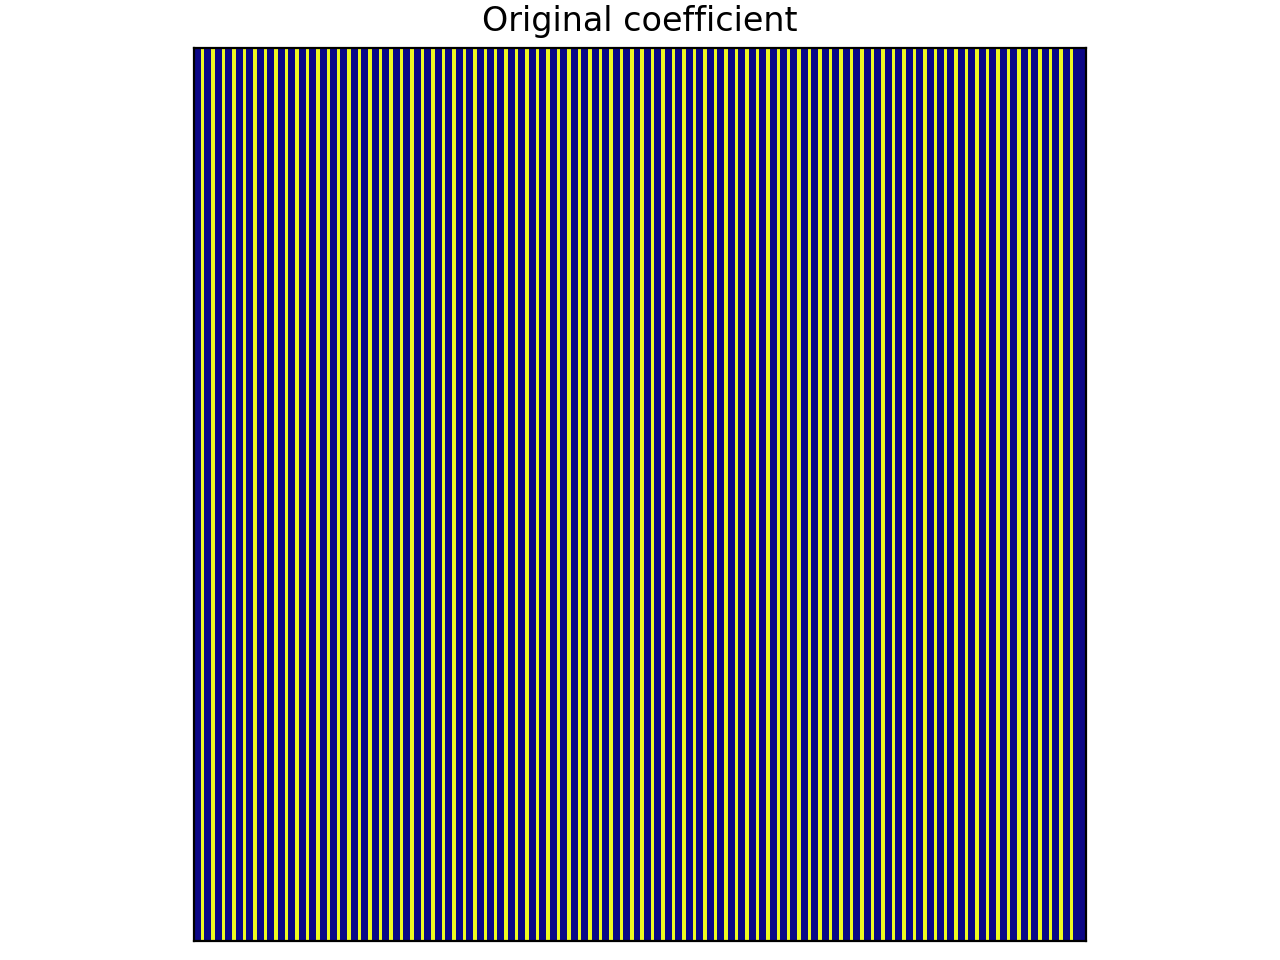

_____Sample__ 1/50 ____
Affected correctors: 256.0
Updated correctors: 51.0
_____Sample__ 2/50 ____
Affected correctors: 256.0
Updated correctors: 51.0
_____Sample__ 3/50 ____
Affected correctors: 256.0
Updated correctors: 50.0
_____Sample__ 4/50 ____
Affected correctors: 256.0
Updated correctors: 51.0
_____Sample__ 5/50 ____
Affected correctors: 256.0
Updated correctors: 51.0
_____Sample__ 6/50 ____
Affected correctors: 256.0
Updated correctors: 51.0
_____Sample__ 7/50 ____
Affected correctors: 256.0
Updated correctors: 51.0
_____Sample__ 8/50 ____
Affected correctors: 208.0
Updated correctors: 42.0
_____Sample__ 9/50 ____
Affected correctors: 192.0
Updated correctors: 38.0
_____Sample__ 10/50 ____
Affected correctors: 176.0
Updated correctors: 35.0
_____Sample__ 11/50 ____
Affected correctors: 256.0
Updated correctors: 51.0
_____Sample__ 12/50 ____
Affected correctors: 256.0
Updated correctors: 51.0
_____Sample__ 13/50 ____
Affected correctors: 208.0
Updated correctors: 40.0
_____Sam

In [ ]:
#background
bg = 0.05
#values
val = 1
random.seed(20)
#fine World
NWorldFine = np.array([256, 256])
NpFine = np.prod(NWorldFine+1)                                                                               

#coarse World
NWorldCoarse = np.array([16,16])
NpCoarse = np.prod(NWorldCoarse+1)

#ratio between Fine and Coarse
NCoarseElement = NWorldFine/NWorldCoarse

boundaryConditions = np.array([[0, 0],
                               [0, 0]])

world = World(NWorldCoarse, NCoarseElement, boundaryConditions)

#righthandside
f = np.ones(NpCoarse)

#coefficient 2
CoefClass = buildcoef2d.Coefficient2d(NWorldFine, 
                        bg                  = bg,
                        val                 = val,
                        length              = 1,
                        thick               = 1,
                        space               = 2,
                        probfactor          = 1,
                        right               = 0,
                        down                = 0,
                        diagr1              = 0,
                        diagr2              = 0,
                        diagl1              = 0,
                        diagl2              = 0,
                        LenSwitch           = None,
                        thickSwitch         = None,
                        equidistant         = True,
                        ChannelHorizontal   = None,
                        ChannelVertical     = True,
                        BoundarySpace       = True)

A = CoefClass.BuildCoefficient()
ABase = A.flatten()
        
plt.figure("OriginalCoefficient")
drawCoefficient(NWorldFine, ABase)
plt.title('Original coefficient')

k = 4

###### precompute #######
NWorldFine = world.NWorldFine
NWorldCoarse = world.NWorldCoarse
NCoarseElement = world.NCoarseElement

boundaryConditions = world.boundaryConditions
NpFine = np.prod(NWorldFine+1)
NpCoarse = np.prod(NWorldCoarse+1)

#interpolant
IPatchGenerator = lambda i, N: interp.L2ProjectionPatchMatrix(i, N, NWorldCoarse, NCoarseElement, boundaryConditions)

#old Coefficient (need flatten form)
ABase = A.flatten()
Aold = coef.coefficientFine(NWorldCoarse, NCoarseElement, ABase)

pglod = pg_rand.VcPetrovGalerkinLOD(Aold, world, k, IPatchGenerator, 0)
pglod.originCorrectors(clearFineQuantities=False)

#correctors that we will update in %
numberofcorrectors = 20

MC = 50
ROOT = '../test_data/MonteCarlo/Coef2/p20'
a, mum = result(pglod, world, CoefClass, A, f, MC, numberofcorrectors, MCplot=True, ROOT=ROOT)

print 'p = '+ str(20) + '%'
print 'uLod  ' + str(mum[0]) + ' +- ' + str(a[0])
print 'uVcLod ' + str(mum[1]) + ' +- ' + str(a[1])
print 'uLodVcLod ' + str(mum[2]) + ' +- ' + str(a[2])

#correctors that we will update in %
numberofcorrectors = 40

ROOT = '../test_data/MonteCarlo/Coef2/p40'
a, mum = result(pglod, world, CoefClass, A, f, MC, numberofcorrectors, MCplot=True, ROOT=ROOT)

print 'p = '+ str(40) + '%'
print 'uLod  ' + str(mum[0]) + ' +- ' + str(a[0])
print 'uVcLod ' + str(mum[1]) + ' +- ' + str(a[1])
print 'uLodVcLod ' + str(mum[2]) + ' +- ' + str(a[2])

plt.show()
